# Домашнее задание: Фильтрация в частотной области

### 1. Начальная настройка и анализ изображения

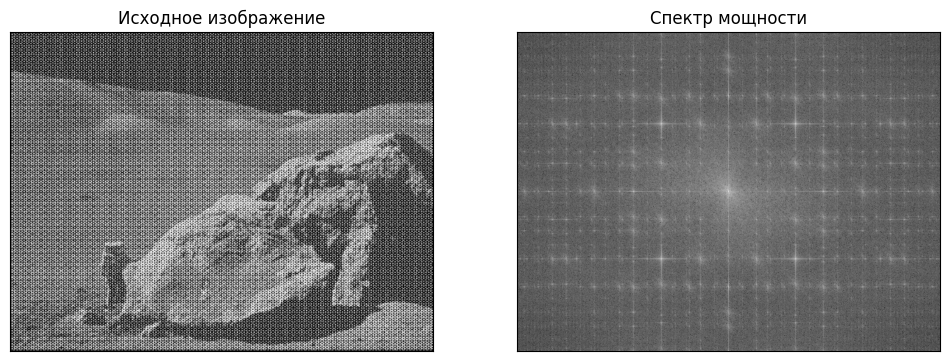

In [14]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

# Загружаем изображение
img = cv.imread('periodic_noise.jpg', cv.IMREAD_GRAYSCALE)

# Выполняем прямое преобразование Фурье
dft = cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

# Визуализируем спектр мощности
magnitude_spectrum = 20 * np.log(cv.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]))

plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title('Исходное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Спектр мощности'), plt.xticks([]), plt.yticks([])
plt.show()

### 2. Реализация высокочастотной фильтрации на основе ядра Гаусса

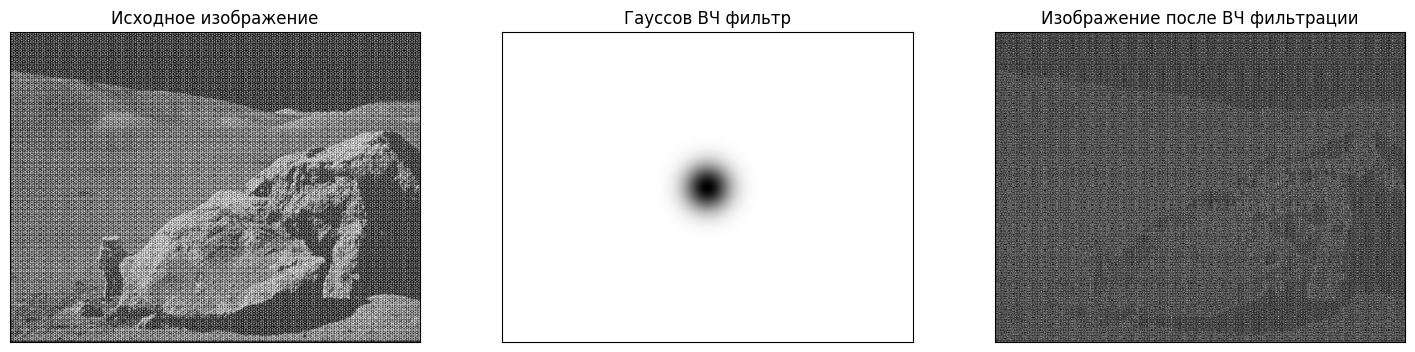

In [15]:
rows, cols = img.shape
crow, ccol = rows // 2 , cols // 2

# Создаем Гауссов низкочастотный фильтр
mask_lpf = np.zeros((rows, cols, 2), np.float32)
radius = 30
for i in range(rows):
    for j in range(cols):
        distance = np.sqrt((i - crow)**2 + (j - ccol)**2)
        mask_lpf[i, j] = np.exp(-(distance**2) / (2 * radius**2))

# Создаем высокочастотный фильтр путем инвертирования низкочастотного
mask_hpf = 1 - mask_lpf

# Применяем фильтр
fshift_hpf = dft_shift * mask_hpf
f_ishift_hpf = np.fft.ifftshift(fshift_hpf)
img_back_hpf = cv.idft(f_ishift_hpf)
img_back_hpf = cv.magnitude(img_back_hpf[:,:,0], img_back_hpf[:,:,1])

# Визуализация результатов
plt.figure(figsize=(18, 6))
plt.subplot(131), plt.imshow(img, cmap='gray')
plt.title('Исходное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(mask_hpf[:,:,0], cmap='gray')
plt.title('Гауссов ВЧ фильтр'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(img_back_hpf, cmap='gray')
plt.title('Изображение после ВЧ фильтрации'), plt.xticks([]), plt.yticks([])
plt.show()

### 3. Реализация удаления периодического шума

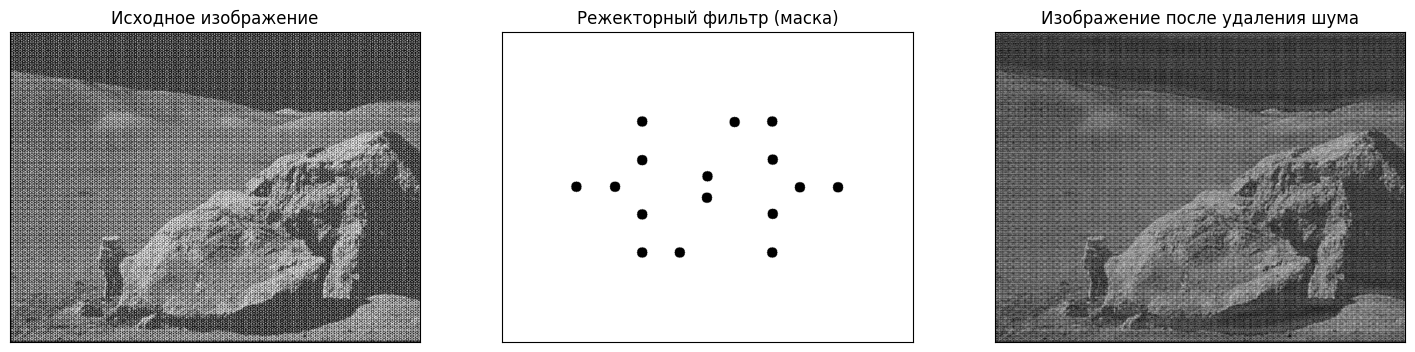

In [16]:
# Создаем режекторный фильтр (notch filter)
# Маска по умолчанию пропускает все частоты (заполнена единицами)
mask_notch = np.ones((rows, cols, 2), np.uint8)

spectrum_for_detection = magnitude_spectrum.copy()
cv.circle(spectrum_for_detection, (ccol, crow), 15, 0, -1)
spectrum_norm = cv.normalize(spectrum_for_detection, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)

# Применяем порог, чтобы выделить только самые яркие пики
# Порог 195 - менять самому
_, thresh = cv.threshold(spectrum_norm, 195, 255, cv.THRESH_BINARY)

contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Вычисляем центры контуров, это и будут координаты шума
noise_points = []
for cnt in contours:
    M = cv.moments(cnt)
    if M['m00'] != 0:
        cX = int(M['m10'] / M['m00'])
        cY = int(M['m01'] / M['m00'])
        noise_points.append((cY, cX)) # OpenCV (x,y) -> numpy (row,col)

radius = 10 # радиус "вырезаемой" области
for r, c in noise_points:
    cv.circle(mask_notch, (c, r), radius, (0,0,0), -1)

# Применяем режекторный фильтр
fshift_notch = dft_shift * mask_notch
f_ishift_notch = np.fft.ifftshift(fshift_notch)
img_back_notch = cv.idft(f_ishift_notch)
img_back_notch = cv.magnitude(img_back_notch[:,:,0], img_back_notch[:,:,1])

# Визуализация результатов
plt.figure(figsize=(18, 6))
plt.subplot(131), plt.imshow(img, cmap='gray')
plt.title('Исходное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(mask_notch[:,:,0], cmap='gray')
plt.title('Режекторный фильтр (маска)'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(img_back_notch, cmap='gray')
plt.title('Изображение после удаления шума'), plt.xticks([]), plt.yticks([])
plt.show()